# PCA and K-means on a music dataset

PCA and K-means are two powerful non parametric techniques that given a dataset allows us to remove noise (PCA) and divide the datapoints into groups, this can be important for community or types detection. In this case we will apply PCA to clean the dataset in order to divide the songs per genre.

## 1. Collecting the data

For this task we'll merge three different datasets. Cleaning and unifying messy and complex data sets for easy access and analysis is a daily challenge for data scientists!

In [1]:
import pandas as pd
import functions as f
import glob
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy as sc
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from scipy.spatial import distance
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

In [2]:
## Load Data
df1 = pd.read_csv('echonest.csv')
df2 = pd.read_csv('features.csv')

#### Checking for NA's

In [ ]:
df1.isnull().sum().head(50)

For the column with over 10 thousand NA's makes sense to drop the whole column as it is not useful for the PCA, while for the other columns where the number of NA's is not drastically big the best way is to interpolate with the 'nearest' method.

In [4]:
df1['metadata_artist_latitude'] = df1['metadata_artist_latitude'].interpolate(method = 'nearest')
df1['metadata_artist_longitude'] = df1['metadata_artist_longitude'].interpolate(method = 'nearest')

#### Merging the data

In [5]:
## Inner Join
df = pd.merge(left = df1, right = df2, left_on = 'track_id', right_on = 'track_id')

## 2. Principal Component Analysis

First thing we have to choose the fetures to apply the PCA, this means we have to drop all the columns with object, categorical data and irrelevant variables.

In [6]:
df_new = df.drop(columns=['metadata_artist_location','metadata_artist_name',
                            'metadata_album_date',
                            'metadata_album_name','metadata_release',
                            'ranks_artist_discovery_rank','ranks_artist_familiarity_rank', 'ranks_artist_hotttnesss_rank',
                            'ranks_song_currency_rank', 'ranks_song_hotttnesss_rank'])

df_pca = df_new.drop(columns=['track_id'])

#### Always standardize the features

Not standardizing the features will lead to wrong results because the scale of the features influences the PCA.

In [7]:
## In this way we standardize the features

x = StandardScaler().fit_transform(df_pca)
x = pd.DataFrame(x)

#### Implementing the model

In [ ]:
pca = PCA()
pca.fit(x)

#### Selecting the number of components

A method to select the number of components is to look at the cumulate percentage of explained variance and choose the one that explaines at least the 70%.

In [9]:
np.cumsum(pca.explained_variance_ratio_)[50:70]

array([0.66438892, 0.66756669, 0.67068784, 0.67379247, 0.67684569,
       0.67980056, 0.68270615, 0.68556014, 0.68839786, 0.69117904,
       0.69393971, 0.69665995, 0.69936076, 0.70198898, 0.70460376,
       0.70712077, 0.70960614, 0.71205547, 0.71446768, 0.71686264])

We can see that the threshold of 70% of explained variance is reached with a total number of 64 components.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


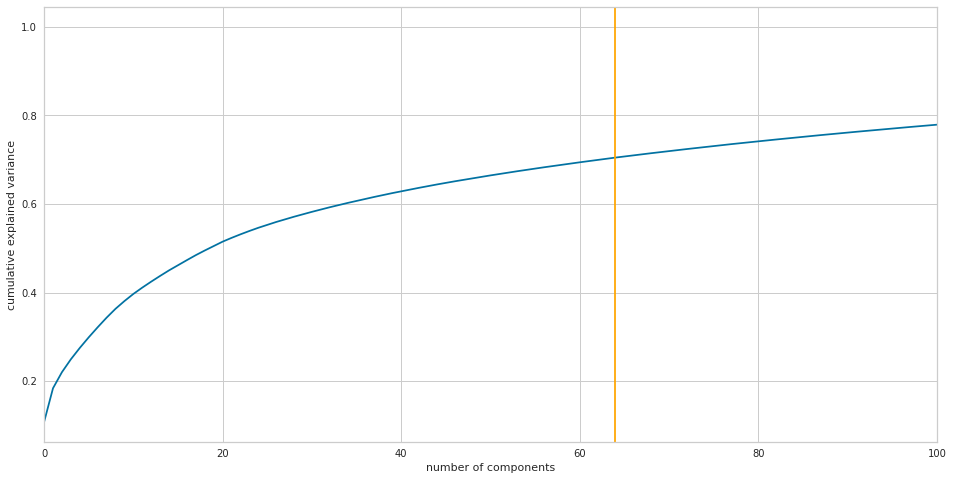

In [10]:
cumulatevariance = np.cumsum(pca.explained_variance_ratio_)
cumulatevariance = cumulatevariance[cumulatevariance <= 0.7019].tolist() 
n = len(cumulatevariance)+1 

plt.figure(figsize=(16,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((0,100))
plt.axvline(n, color = 'orange');

## 3. K-means from scratch

To divide the songs into cluster we will implement K-Means algorithm from scratch on the PCA'd dataframe

In [ ]:
dataset = f.load_pickle('pca.pickle')

In [11]:
# you can skip this part by running the command above

dataset = pd.DataFrame(pca.transform(x))
dataset = dataset.iloc[:, :n]

#### Selecting the number of clusters
This can be done by looking at the scree plot by finding the elbow.

In [12]:
## Clustering
K = 20

labels = []
centers = []

for k in range(2,K+1):
    label,center = f.kmeans(dataset,k)
    labels.append(label)
    centers.append(center)

#### Elbow method

In [13]:
## Within cluster sum of square

Within = []
for center in centers:
    within = np.min(distance.cdist(dataset, center, 'euclidean'),axis=1)
    within=within**2
    Within.append(sum(within))



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


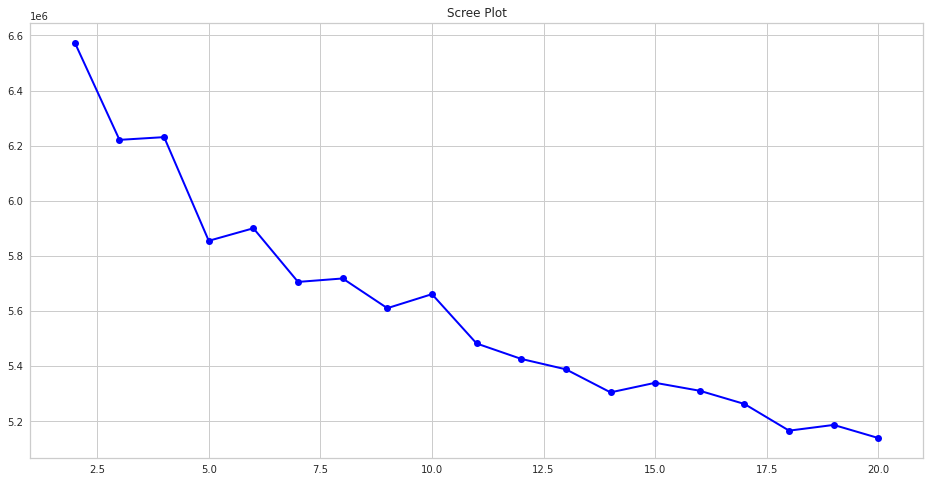

In [14]:
## Scree Plot 

import matplotlib.pyplot as plt
import numpy as np

x = []

for i in range(2,K+1):
    x.append(i)


plt.figure(figsize=(16,8))
plt.plot(x, Within, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlim((1,21))
plt.show()

From the scree plot we can see that the suggested number of clusters is 10 because we can clearly see an elbow (where the function stops decreasing fast)

#### Plotting the clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


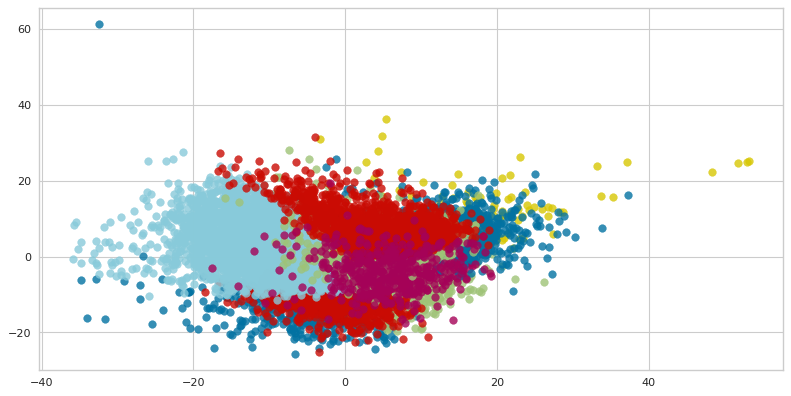

In [15]:
d = dataset.to_numpy()

figure(figsize = (12, 6), dpi = 80)

u_labels = np.unique(labels[8])

for i in u_labels:

    plt.scatter(d[labels[8] == i , 0] , d[labels[8] == i , 1] , alpha=0.8)

plt.legend()

plt.show()

## 4. Pivotal Tables to understand the results

We'll select some variables that we think are relevant to identify the genre of a song. For example, Duration, Language, Country, etc.

In [17]:
df3 = f.load_pickle('tracks.pickle')

In [9]:
#We are gonna take all the variables regarding the sound of every song
Identifiers = df1[['audio_features_acousticness','audio_features_danceability',
                   'audio_features_energy','audio_features_instrumentalness','audio_features_liveness', 
                   'audio_features_speechiness', 'audio_features_valence']]

#Let's give a cleaner look to the data!
Identifiers = Identifiers.rename(columns={'audio_features_acousticness':'Acousticness', 'audio_features_danceability':'Danceability',
                           'audio_features_energy':'Energy', 'audio_features_instrumentalness':'Instrumentalness', 
                           'audio_features_liveness': 'Liveness', 'audio_features_speechiness':'Speechiness', 
                           'audio_features_valence':'Valence'})
Identifiers.head(11)

,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.576661
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.269240
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.621661
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.963590
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.894072
5,0.106550,0.260911,0.607067,0.835087,0.223676,0.030569,0.160267
6,0.376312,0.734079,0.265685,0.669581,0.085995,0.039068,0.609991
7,0.963657,0.435933,0.075632,0.345493,0.105686,0.026658,0.163950
8,0.662881,0.379065,0.823856,0.910266,0.088705,0.079090,0.092868
9,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,0.788251


On the web we found that the variables have the following meanings:

**Acousticness** describes how acoustic a song is. 

**Danceability** describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

**Energy** represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

**Instrumentalness** represents the amount of vocals in the song.

**Liveness** describes the probability that the song was recorded with a live audience.

**Speechiness** detects the presence of spoken words in a track.

**Valence** represents the musical positiveness conveyed by a track.


#### Categorizing the data

In [10]:
#CATEGORIZATION OF DATA
for i in range(len(Identifiers)):
    for j in range(len(Identifiers.columns)):
        if (Identifiers.values[i][j]<0.25):
            Identifiers.values[i][j] = 1
        elif (Identifiers.values[i][j]>=0.25) & (Identifiers.values[i][j]<0.5):
            Identifiers.values[i][j] = 2
        elif (Identifiers.values[i][j]>=0.5) & (Identifiers.values[i][j]<0.75):
            Identifiers.values[i][j] = 3
        else:
            Identifiers.values[i][j] = 4

#### Pivoting

With the selected variables, we perform pivot tables. On the horizontal axis the clusters and on the vertical axis the categories of each variable. Notice that you have to do one pivot table per variable.

In [11]:
labels_10 = labels[8] + 1
Identifiers['#Cluster'] = labels_10
Identifiers.head(11)

NameError: name 'labels' is not defined

Pivot table for the Acousticness

In [ ]:
round(pd.crosstab(index=Identifiers['Acousticness'], columns=Identifiers['#Cluster'], normalize='columns')*100, 2)

#Cluster,1,2,3,4,5,6,7,8,9,10
Acousticness,,,,,,,,,,
1.0,42.39,0.77,11.57,69.61,42.88,0.0,2.55,14.39,41.19,43.06
2.0,11.59,0.00,6.02,14.75,16.62,0.0,3.21,10.09,12.22,18.81
3.0,14.26,0.19,7.87,9.65,14.25,0.0,4.53,15.84,14.27,17.73
4.0,31.76,99.04,74.54,6.00,26.25,100.0,89.71,59.67,32.32,20.40


The acousticness is typical of "genuine" music (music without electronic or artificial sounds). 

The table shows that the clusters 2, 3, 6 and 7 have a big acoustic component, so these groups may represent classic music or historical music.

#### Comparing the results with the real genres

This will allow us to answer what is the most representative genre for each one of the clusters.

In [ ]:
round(pd.crosstab(index=Identifiers['Genre'], columns=Identifiers['#Cluster'], normalize='columns')*100, 2)

#Cluster,1,2,3,4,5,6,7,8,9,10
Genre,,,,,,,,,,
Blues,0.50,0.22,0.00,0.21,0.50,0.0,1.88,1.57,0.00,0.40
Classical,0.10,9.05,12.41,0.10,0.20,0.0,23.95,1.63,0.27,0.27
Electronic,5.11,1.10,30.66,49.69,52.05,100.0,16.02,11.35,20.00,36.56
Experimental,0.10,0.44,0.00,0.10,0.20,0.0,0.43,0.16,0.13,0.20
Folk,3.33,9.93,27.74,2.90,1.40,0.0,24.82,25.41,2.55,1.53
Hip-Hop,1.49,0.00,3.65,17.12,24.12,0.0,1.15,2.50,5.23,24.95
Instrumental,0.45,0.66,0.73,0.31,0.90,0.0,1.15,2.06,0.54,0.60
International,0.79,1.10,3.65,0.00,1.10,0.0,2.45,2.88,1.21,1.13
Jazz,0.74,1.55,0.73,1.56,2.50,0.0,10.25,4.07,1.07,1.59


From the obtained results we can conclude that the clustering has in part succeded: we can observe that our clustering has captured some genres like Old-time/Historic, Rock and Classical are mainly contained into some specific clusters. Old-time features are mainly contained into Cluster 2, Rock's are primarly contained into Cluster 1 and Classical variables are mostly contained into Cluster 7.


Although the clustering is not so accurate because we are working in unsupervised contexts and we are unaware of the "ground truth" at the base of the data. It can be useful in cases like these to be supported by people with specific knowledge of the field of which the data are part so as to be able to have a more accurate technical opinion regarding the features present in the dataset and any results obtained.